# HR ANALYTICS

In a particular company, deciding the ideal employee to be promoted has an entire process defined. The example that I have taken is a Binary Classification use case to select the potential employees suitable for a promotion. The features that decide the performance of the employees are:

**employee_id, department, region, education, gender, recruitment_channel, no_of_trainings, age, previous_year_rating, length_of_service, KPI's_met>80%, awards_won, avg_training_score**

The target label is **is_promoted**


In [2]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE

In [3]:
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
mm = MinMaxScaler()
le = LabelEncoder()

In [74]:
#uploaded = files.upload()
df = pd.read_csv(r'C:\Users\test\Desktop\IBM\HR analytics.csv')

In [82]:
df.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [7]:
df.drop(['employee_id'],axis=1,inplace=True)

In [79]:
# COLUMN_NAMES, CATEGORICAL_COLUMNS, NUMERICAL_COLUMNS
columns = df.columns.to_list()
categorical = [feature for feature in columns if df[feature].dtypes == 'O']
numerical = [feature for feature in columns if feature not in categorical]

In [81]:
# NULL values
for feature in columns:
  print(feature,':',df[feature].isna().sum()/len(df[feature])*100)

employee_id : 0.0
department : 0.0
region : 0.0
education : 4.395343745438622
gender : 0.0
recruitment_channel : 0.0
no_of_trainings : 0.0
age : 0.0
previous_year_rating : 7.524448985549554
length_of_service : 0.0
KPIs_met >80% : 0.0
awards_won? : 0.0
avg_training_score : 0.0
is_promoted : 0.0


Education has **4.39%** missing values
previous_year_rating has **7.52%** missing values

In [76]:
# UNIQUE VALUES in categorical
for feature in categorical:
  print(feature,':',len(df[feature].unique()))

department : 9
region : 34
gender : 2
recruitment_channel : 3


In [77]:
# UNIQUE VALUES in numerical
for feature in numerical:
  print(feature,':',len(df[feature].unique()))

no_of_trainings : 10
age : 41
previous_year_rating : 6
length_of_service : 35
KPIs_met >80% : 2
awards_won? : 2
avg_training_score : 61
is_promoted : 2


*   **department, region, gender, recruitment channel** are nominal variables
*   **education** is an ordinal variable
*   All **Numerical** variables are descrete 






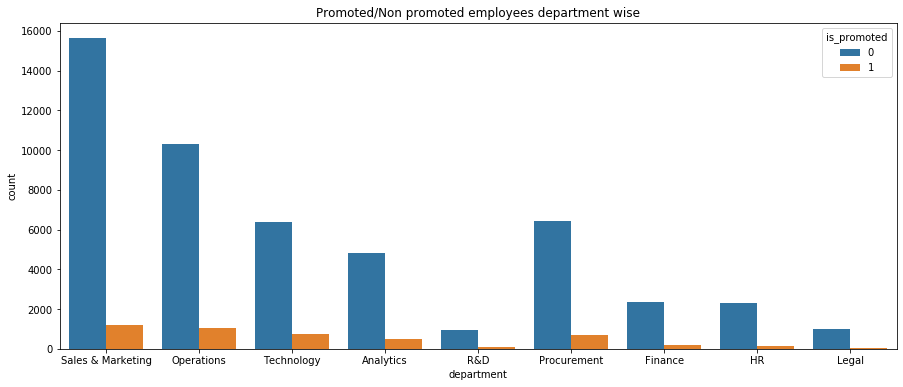

In [83]:
# Number of promoted and non promoted employees in various departments
plt.figure(figsize=(15,6))
plt.title('Promoted/Non promoted employees department wise')
sns.countplot(df['department'], hue=df['is_promoted'])

Most of the employees are from **Sales and Marketing** AND Sales & Marketing, Operations, Technology, Procurement are the departments where most of the promotions have taken place 

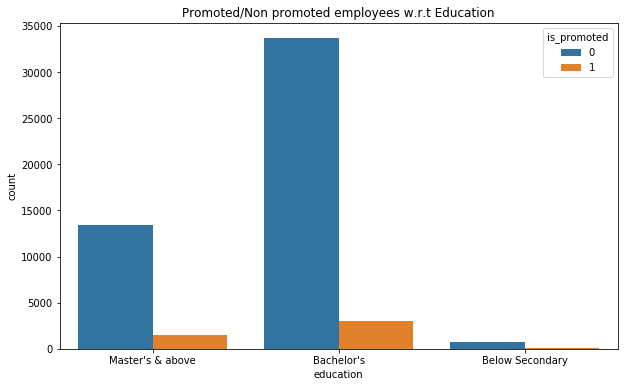

In [85]:
# Number of promoted and non promoted employees with respect to their education
plt.figure(figsize=(10,6))
plt.title('Promoted/Non promoted employees w.r.t Education')
sns.countplot(df['education'], hue=df['is_promoted'])

More number of employees with a Bachelor's degree have been promoted as compared to employees with masters degree. 

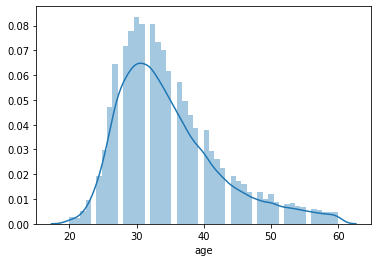

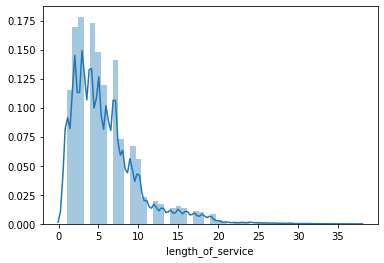

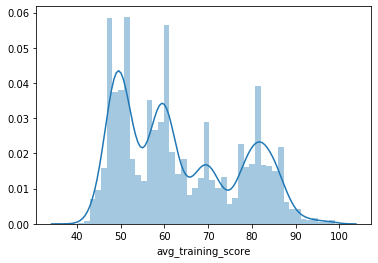

In [56]:
# Distribution of Numerical Features
sns.distplot(df['age'])
plt.show()
sns.distplot(df['length_of_service'])
plt.show()
sns.distplot(df['avg_training_score'])
plt.show()

Most of the employees are in their early 30's and the length of service is also around 3 - 7. Hence both these variables are positively skewed

0    91.482995
1     8.517005
Name: is_promoted, dtype: float64


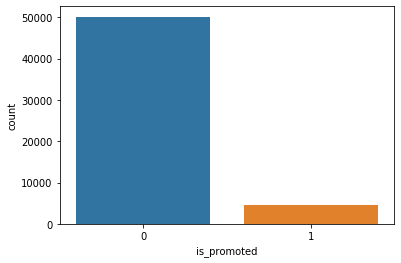

In [15]:
# Count of label class
print(df['is_promoted'].value_counts(normalize=True)*100)
sns.countplot(df['is_promoted'])

The class label is highly imbalanced **9:1** and so an upsampling approach will be implemented

## IMPUTING MISSING Values

In [16]:
# IMPUTING MISSING VALUES

df['education'].fillna(df['education'].mode()[0],inplace=True)
df['previous_year_rating'].fillna(df['previous_year_rating'].mean(),inplace=True)

## ENCODING CATEGORICAL VARIABLES 

In [17]:
# EDUCATION - Masters > Bachelors > Below Secondary
education_map = {"Master's & above":3,"Bachelor's":2,"Below Secondary":1}
df['education'] = df['education'].map(education_map)
categorical.remove('education')

In [18]:
# LABEL ENCODING for other categorical features
for feature in categorical:
  str_feature = df[feature].astype(str)
  df[feature] = le.fit_transform(str_feature)

## FEATURE CREATION

*   **TOTAL SCORE**   Average training score * Number of trainings 
*   **Award_KPI**   Awards won + KPI's met.
*   **Experience**   Age - Length of service






In [19]:
df['total_score'] = df['avg_training_score']*df['no_of_trainings']
df['award_kpi'] = df['awards_won?']+df['KPIs_met >80%']
df['experience'] = df['age'] - df['length_of_service']

## CORELATION between Features and Target

In [20]:
# Corelation b/w target and features
df[columns].corr().loc['is_promoted'].sort_values(ascending=False)

is_promoted             1.000000
KPIs_met >80%           0.221582
awards_won?             0.195871
avg_training_score      0.181147
previous_year_rating    0.153406
education               0.028026
region                  0.008841
recruitment_channel     0.002229
department              0.000130
length_of_service      -0.010670
gender                 -0.011109
age                    -0.017166
no_of_trainings        -0.024896
Name: is_promoted, dtype: float64

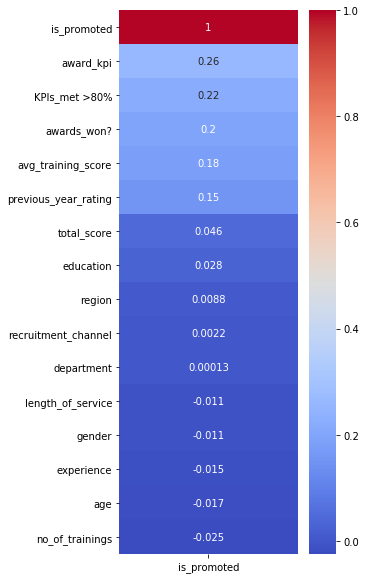

In [73]:
plt.figure(figsize=(4,10))
sns.heatmap(df.corr()[['is_promoted']].sort_values(by=['is_promoted'],ascending=False),cmap='coolwarm',annot=True,)

## OVER_SAMPLING USING SMOTE

In [24]:
df1 = df.copy()
x = df1.drop(['is_promoted'],axis=1)
y = df1['is_promoted']

In [25]:
# MinMax Scaler
xx = mm.fit_transform(x)

In [26]:
oversample = SMOTE()
x1,y1 = oversample.fit_resample(x,y)

In [27]:
# Train Test Split
x_train,x_test,y_train,y_test = train_test_split(x1,y1,test_size=0.2,random_state=42)

## Defining MODELS

### Random Forest Classifier

In [28]:
# Random ForesT Classifier using GRIDSEARCHCV

param_grid = {'criterion':['gini','entropy'],
              'n_estimators':[100,200,400]
              }
rfc = RandomForestClassifier()
grid_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, n_jobs=-1, cv = 3)

In [29]:
grid_rfc.fit(x_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': [100, 200, 400]})

In [30]:
grid_rfc.best_estimator_

RandomForestClassifier(n_estimators=200)

In [31]:
grid_rfc.best_params_

{'criterion': 'gini', 'n_estimators': 200}

In [88]:
pred_rfc = grid_rfc.predict(x_test)
print('Classification Report RFC: \n', classification_report(y_test, pred_rfc))
print('Accuracy RFC : ',grid_rfc.score(x_test,y_test)*100)

Classification Report RFC: 
               precision    recall  f1-score   support

           0       0.96      0.95      0.96     10197
           1       0.95      0.96      0.96      9859

    accuracy                           0.96     20056
   macro avg       0.96      0.96      0.96     20056
weighted avg       0.96      0.96      0.96     20056

Accuracy RFC :  95.62724371759074


## ANN

In [34]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [35]:
model = Sequential()
model.add(Dense(300, input_dim = 15, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(150, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))

In [36]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [37]:
model.fit(x_train,y_train,epochs=10,batch_size=100)


Epoch 1/10
80224/80224 [==============================] - 3s 39us/step - loss: 0.6837 - accuracy: 0.6531
Epoch 2/10
80224/80224 [==============================] - 3s 32us/step - loss: 0.5520 - accuracy: 0.7155
Epoch 3/10
80224/80224 [==============================] - 2s 30us/step - loss: 0.5286 - accuracy: 0.7298
Epoch 4/10
80224/80224 [==============================] - 2s 30us/step - loss: 0.5146 - accuracy: 0.7361
Epoch 5/10
80224/80224 [==============================] - 2s 30us/step - loss: 0.5077 - accuracy: 0.7380
Epoch 6/10
80224/80224 [==============================] - 2s 30us/step - loss: 0.4963 - accuracy: 0.7458
Epoch 7/10
80224/80224 [==============================] - 2s 30us/step - loss: 0.4888 - accuracy: 0.7496
Epoch 8/10
80224/80224 [==============================] - 2s 30us/step - loss: 0.4749 - accuracy: 0.7571
Epoch 9/10
80224/80224 [==============================] - 2s 31us/step - loss: 0.4645 - accuracy: 0.7632
Epoch 10/10
80224/80224 [=============================

In [91]:
accuracy = model.evaluate(x_test,y_test)

20056/20056 [==============================] - 0s 23us/step


In [94]:
pred_ann = model.predict(x_test)
pred_ann = np.round(pred_ann)

In [106]:
print('Classification Report ANN : \n', classification_report(y_test, pred_ann))
print('Accuracy ANN : ',accuracy[1]*100)

Classification Report ANN : 
               precision    recall  f1-score   support

           0       0.88      0.68      0.76     10197
           1       0.73      0.90      0.81      9859

    accuracy                           0.79     20056
   macro avg       0.80      0.79      0.78     20056
weighted avg       0.80      0.79      0.78     20056

Accuracy ANN :  78.69964241981506


In [39]:
print('accuracy : ', accuracy[1], '\n loss : ', accuracy[0])

accuracy :  0.7869964241981506 
 loss :  0.42671994425692217


## XGBClassifier

In [40]:
params_xgb = {"learning_rate" : [0.05, 0.10, 0.15] ,
              "max_depth" : [ 3, 4, 5],
              "min_child_weight" : [ 1, 3],
              "gamma" : [ 0.1, 0.2 , 0.3],
              "colsample_bytree" : [ 0.3, 0.4] }
xgb = XGBClassifier()
ran_xgb = RandomizedSearchCV(estimator=xgb, param_distributions=params_xgb,n_iter=5,n_jobs=-1)

In [41]:
ran_xgb.fit(x_train,y_train)

RandomizedSearchCV(estimator=XGBClassifier(), n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4],
                                        'gamma': [0.1, 0.2, 0.3],
                                        'learning_rate': [0.05, 0.1, 0.15],
                                        'max_depth': [3, 4, 5],
                                        'min_child_weight': [1, 3]})

In [42]:
ran_xgb.best_estimator_

XGBClassifier(colsample_bytree=0.4, gamma=0.2, learning_rate=0.15,
              min_child_weight=3)

In [43]:
ran_xgb.best_params_

{'min_child_weight': 3,
 'max_depth': 3,
 'learning_rate': 0.15,
 'gamma': 0.2,
 'colsample_bytree': 0.4}

In [107]:
pred_xgb = ran_xgb.predict(x_test)
print('Classification Report XGB: \n', classification_report(y_test, pred_xgb))
print('Accuracy XGB: ',ran_xgb.score(x_test,y_test)*100)

Classification Report XGB: 
               precision    recall  f1-score   support

           0       0.86      0.91      0.88     10197
           1       0.90      0.85      0.87      9859

    accuracy                           0.88     20056
   macro avg       0.88      0.88      0.88     20056
weighted avg       0.88      0.88      0.88     20056

Accuracy XGB:  87.94375747905863


## Decision Tree Classifier, Logistic Regression 

In [60]:
dtc = DecisionTreeClassifier()
lr = LogisticRegression(max_iter=10000)

In [61]:
dtc.fit(x_train,y_train)
lr.fit(x_train,y_train)

LogisticRegression(max_iter=10000)

## Comparing Models 

In [63]:
models = {'Random Forest Classifier':grid_rfc.score(x_test,y_test),
          'ANN':accuracy[1],
          'XGBoost Classifier':ran_xgb.score(x_test,y_test),
          'Decision Tree Classifier':dtc.score(x_test,y_test),
          'Logistic Regression':lr.score(x_test,y_test)}

In [69]:
model_name = list(models.keys())
model_score = np.round(list(models.values()),2)

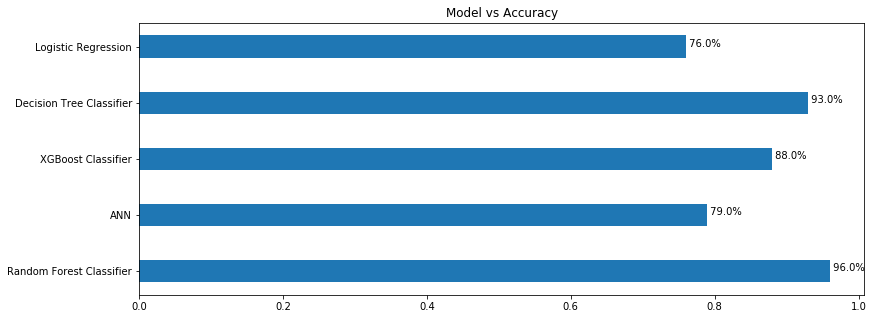

In [121]:
plt.figure(figsize = (13,5))
plt.barh(model_name,model_score,height=0.4)
plt.title('Model vs Accuracy')
for index,value in enumerate(model_score):
    plt.text(value,index," "+str(value*100)+"%")